In [4]:
import yfinance as yf
import pandas as pd
from finta import TA
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
def add_ta_features(df_):
    """
    Adds technical analysis features to dataframe
    :param df_: dataframe to add technical analysis features to
    :return: dataframe with technical analysis features
    """
    # get all functions in finta
    finta_functions = [func for func in dir(TA) if callable(getattr(TA, func)) and not func.startswith("__")]
    # loop through all functions in finta and append the results to the dataframe
    # skip functions that throw errors
    for func in finta_functions:
        try:
            df_[func] = getattr(TA, func)(df_)
        except:
            pass
    return df_

def add_time_features(df_):
    # get frequency of data
    freq = pd.infer_freq(df_.index)
    # if frequency is daily, assume data includes weekends
    if freq == 'D':
        include_weekends = True
    else:
        include_weekends = False

    # get number of days in week, month, year
    if include_weekends:
        days_in_week = 7
        days_in_month = 31
        days_in_year = 365
    else:
        days_in_week = 5
        days_in_month = 21
        days_in_year = 250
    # add weekday, monthday, yearday features
    df_['weekday'] = df_.index.dayofweek
    df_['monthday'] = df_.index.day
    df_['yearday'] = df_.index.dayofyear
    # add sine and cosine of weekday, monthday, yearday features
    df_['sin_weekday'] = np.sin(2 * np.pi * df_['weekday'] / days_in_week)
    df_['cos_weekday'] = np.cos(2 * np.pi * df_['weekday'] / days_in_week)
    df_['sin_monthday'] = np.sin(2 * np.pi * df_['monthday'] / days_in_month)
    df_['cos_monthday'] = np.cos(2 * np.pi * df_['monthday'] / days_in_month)
    df_['sin_yearday'] = np.sin(2 * np.pi * df_['yearday'] / days_in_year)
    df_['cos_yearday'] = np.cos(2 * np.pi * df_['yearday'] / days_in_year)
    # drop weekday, monthday, yearday features
    df_.drop(['weekday', 'monthday', 'yearday'], inplace=True, axis=1)
    return df_

In [37]:
def create_data(ticker='^GSPC', start_='2005-01-01', end_='2022-12-31', interval_='1d', fillna=True, scale_to_std=True, fill_weekends=False, add_time_features_=True, test_split=0.2, shuffle=False):
    """
    Creates dataframe with technical analysis features
    :param ticker: ticker symbol to download data for (default is S&P 500)
    :param start_: start date
    :param end_: end date
    :param interval_: data frequency
    :param fillna: whether to fill in missing values
    :param scale_to_std: whether to scale to standard deviation
    :param fill_weekends: whether to fill in weekends
    :return: dataframe with technical analysis features
    """
    # download data
    data_df = yf.download(ticker, start_, end_, interval=interval_, progress=False)
    # rename columns
    data_df.rename(columns={"Open": "open", "Adj Close": "close", "High": "high", "Low": "low", "Volume": "volume"}, inplace=True)
    # drop close column
    data_df.drop("Close", inplace=True, axis=1)

    # fill weekends
    if fill_weekends:
        data_df = data_df.resample('D').ffill()

    data_df = add_ta_features(data_df)

    # add technical analysis features
    if add_time_features_:
        data_df = add_time_features(data_df)

    # fill in missing values
    if fillna:
        data_df.fillna(method='bfill', inplace=True)
        data_df.fillna(method='ffill', inplace=True)

    train_df = data_df.iloc[:int(len(data_df) * (1 - test_split))]
    test_df = data_df.iloc[int(len(data_df) * (1 - test_split)):]

    # scale to standard deviation, by column
    if scale_to_std:
        std_ = train_df.std()
        mean_ = train_df.mean()
        train_df = (train_df - mean_) / std_
        test_df = (test_df - mean_) / std_
    if shuffle:
        train_df = train_df.sample(frac=1)
        test_df = test_df.sample(frac=1)
    return train_df, test_df

In [12]:
# a function that takes a dataframe and implements a sliding window mechanism with a given window size
# return a list of windows as dataframes
def sliding_window(df, window_size=10):
    """
    Creates a sliding window mechanism for a given dataframe
    :param df: dataframe
    :param window_size: window size
    :return: list of windows as dataframes
    """
    windows = []
    for i in range(len(df) - window_size + 1):
        windows.append(df.iloc[i:i + window_size])
    return windows

In [120]:
train, test = create_data(end_='2023-04-13',scale_to_std=True, fill_weekends=True)

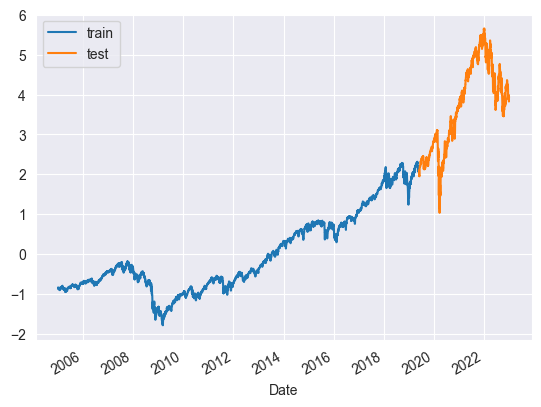

In [9]:
train['close'].plot()
test['close'].plot()
plt.legend(['train', 'test'])

In [126]:
train

,open,high,low,close,volume,ADL,ADX,AO,ATR,BBWIDTH,...,WILLIAMS,WMA,WOBV,ZLEMA,sin_weekday,cos_weekday,sin_monthday,cos_monthday,sin_yearday,cos_yearday
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,-0.828378,-0.832208,-0.833511,-0.846067,-1.734027,-1.378930,6.948460,0.126877,-0.754256,-0.642019,...,-1.260733,-0.872613,0.135244,-0.906872,-0.000465,1.414039,0.796208,1.198963,0.046946,1.419174
2005-01-04,-0.845615,-0.853129,-0.859709,-0.870643,-1.566161,-1.380606,6.948460,0.126877,-0.754256,-0.642019,...,-1.260733,-0.872613,0.135244,-0.906872,1.105224,0.881679,1.011377,1.010820,0.071319,1.417713
2005-01-05,-0.870193,-0.876061,-0.862640,-0.878193,-1.551866,-1.382885,6.948460,0.126877,-0.754256,-0.642019,...,-1.260733,-0.872613,0.129352,-0.906872,1.378307,-0.314523,1.184958,0.782412,0.095664,1.415834
2005-01-06,-0.877743,-0.877985,-0.863430,-0.870923,-1.687469,-1.382668,6.948460,0.126877,-0.754256,-0.642019,...,-1.260733,-0.872613,0.134472,-0.906872,0.613146,-1.273803,1.309845,0.523090,0.119973,1.413539
2005-01-07,-0.870473,-0.876988,-0.865377,-0.873901,-1.760301,-1.383051,6.948460,0.126877,-0.754256,-0.642019,...,-1.260733,-0.872613,0.132496,-0.906872,-0.614077,-1.273803,1.380925,0.243470,0.144238,1.410828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-12,2.141192,2.123583,2.101925,2.097818,-0.282356,1.704554,0.884059,-1.814083,2.784154,0.694110,...,-0.947144,2.141178,1.395297,2.113142,-0.000465,1.414039,0.908476,-1.055843,-0.955616,-1.054659
2019-08-13,2.095032,2.186083,2.108786,2.174225,0.139800,1.707028,0.825832,-1.779960,3.097102,0.628342,...,-0.243822,2.149659,1.527567,2.114086,1.105224,0.881679,0.675724,-1.220849,-0.973925,-1.038597
2019-08-14,2.118558,2.100091,2.043140,2.024073,0.513513,1.701535,0.821700,-1.966371,3.282314,0.748592,...,-1.620025,2.128296,1.236101,2.095515,1.378307,-0.314523,0.415126,-1.334755,-0.991954,-1.022224


In [19]:
import json

In [20]:
with open('fear_greed.json') as f:
    data = json.load(f)

In [26]:
fear = pd.DataFrame(data[0], columns=['index','value'],)

In [28]:
fear.index = pd.to_datetime(fear['index'])

In [30]:
fear  = fear.drop('index', axis=1)

In [34]:
fear['value'] =fear['value'].astype('float')

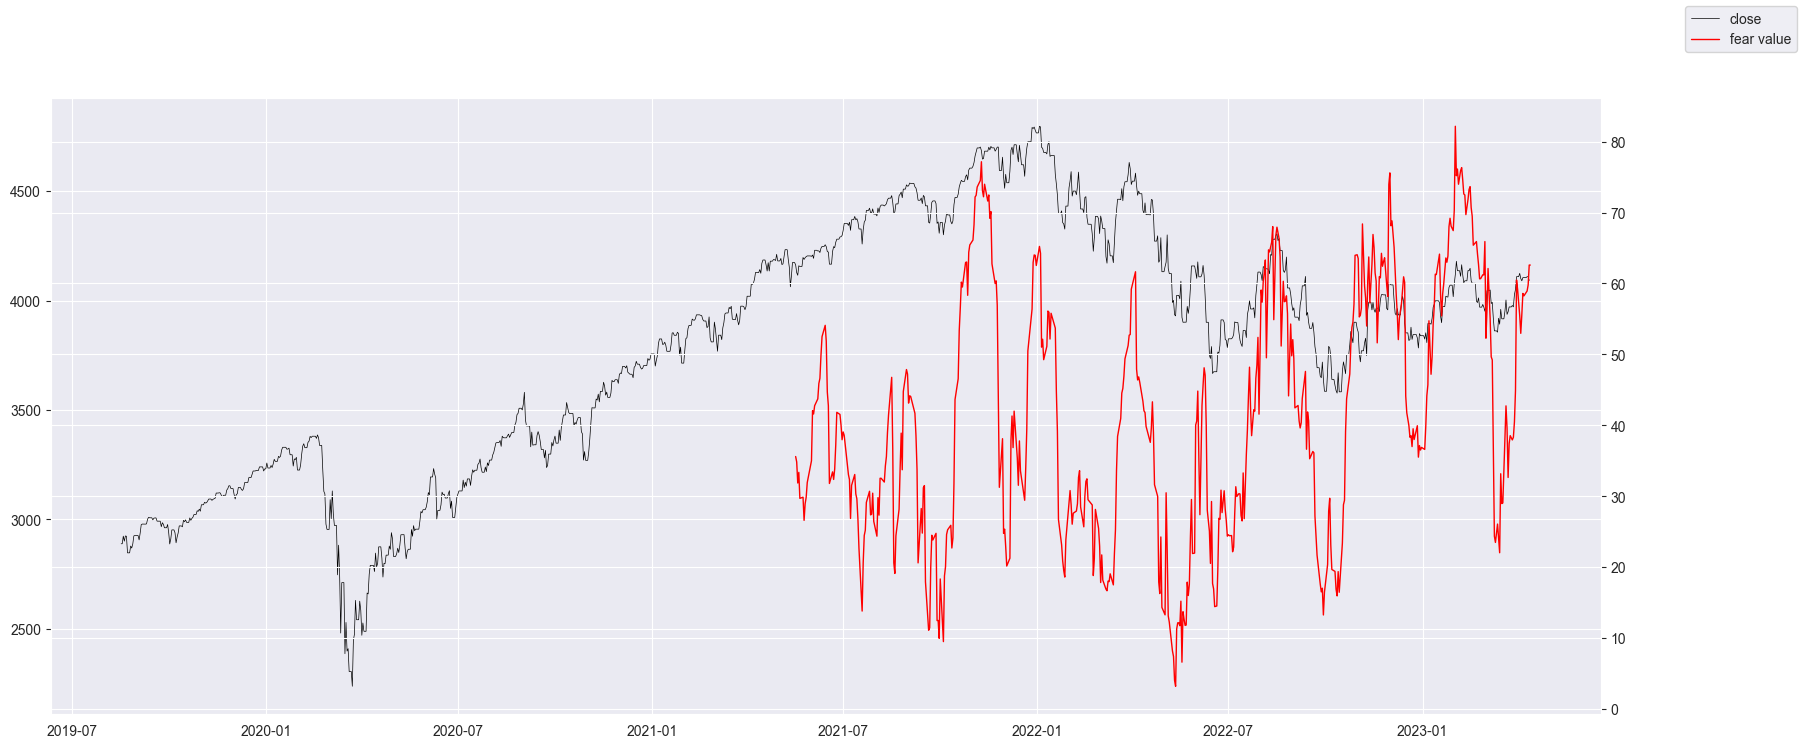

In [110]:
# plot close price and buy/sell signals
fig, ax1 = plt.subplots(figsize=(20, 8))
ax2 = ax1.twinx()

ax1.plot(test['close'], label='close', linewidth=0.5, color='black')


ax2.plot(fear['value'], label='fear value', linewidth=1, color='red')

fig.legend()
plt.show()


In [111]:
test = test[fear.index[0]:fear.index[-1]]

In [118]:
cash = 1000
shares = 0
sell_threshold = 75
buy_threshold = 25
buying = []
selling = []
for i in range(len(fear)):
    if fear['value'].iloc[i] < buy_threshold:
        if shares == 0:
            print('cash: ', cash, 'shares: ', shares, 'price: ', test['close'].iloc[i], 'buying')
            shares = cash / test['close'].iloc[i]
            cash = 0
            buying.append(i)
    elif fear['value'].iloc[i] > sell_threshold:
        if shares > 0:
            print('cash: ', cash, 'shares: ', shares, 'price: ', test['close'].iloc[i], 'selling')
            cash = shares * test['close'].iloc[i]
            shares = 0
            selling.append(i)
# sell remaining shares
print(shares)
if shares > 0:
    print('cash: ', cash, 'shares: ', shares, 'price: ', test['close'].iloc[-1], 'selling')
    cash = shares * test['close'].iloc[-1]
    shares = 0
    selling.append(len(fear))
print(cash)
print('Made: ', (cash - 1000)/1000, '% in ', len(fear), 'days')
print('Annualized return: ', (cash - 1000)/1000 * 365 / len(fear), '%')

cash:  1000 shares:  0 price:  4290.60986328125 buying
cash:  0 shares:  0.23306710045066847 price:  4432.990234375 selling
cash:  1033.1841802519104 shares:  0 price:  4357.0400390625 buying
cash:  0 shares:  0.2371298337837216 price:  3899.3798828125 selling
cash:  924.6593034709159 shares:  0 price:  3719.0400390625 buying
0.24862848846983782
cash:  0 shares:  0.24862848846983782 price:  4091.949951171875 selling
1017.3753312540899
Made:  0.01737533125408993 % in  528 days
Annualized return:  0.012011355885876563 %


In [94]:
buying

[42, 137, 499]

In [95]:
selling

[123, 418, 528]

In [96]:
len(fear)

528

In [98]:
fear['value'].iloc[499]

24.3714

In [107]:
test

,open,high,low,close,volume,ADL,ADX,AO,ATR,BBWIDTH,...,WILLIAMS,WMA,WOBV,ZLEMA,sin_weekday,cos_weekday,sin_monthday,cos_monthday,sin_yearday,cos_yearday
Date,,,,,,,,,,,,,,,,,,,,,
2021-05-17,4169.919922,4171.919922,4142.689941,4163.290039,4125050000,1.728833e+12,22.122839,-5.311117,49.993687,0.035560,...,-41.261832,4151.311176,3.848478e+12,4173.187266,0.000000,1.000000,-9.308737e-01,0.365341,-0.297042,-0.954865
2021-05-18,4165.939941,4169.149902,4125.990234,4127.830078,4398150000,1.724810e+12,21.272257,-8.783204,51.665806,0.035927,...,-60.835651,4144.543403,3.692520e+12,4165.876374,0.951057,0.309017,-7.818315e-01,0.623490,-0.320944,-0.947098
2021-05-19,4098.450195,4116.930176,4061.409912,4115.680176,4247450000,1.728866e+12,21.421703,-13.300625,53.412266,0.037697,...,-67.542370,4136.229199,3.640914e+12,4156.455917,0.587785,-0.809017,-5.633201e-01,0.826239,-0.344643,-0.938734
2021-05-20,4121.970215,4172.799805,4121.970215,4159.120117,3978880000,1.730704e+12,20.527394,-8.618279,54.876517,0.037072,...,-43.563620,4138.512760,3.813756e+12,4156.242892,-0.587785,-0.809017,-2.947552e-01,0.955573,-0.368125,-0.929776
2021-05-21,4168.609863,4188.720215,4151.720215,4155.859863,3995250000,1.727602e+12,19.429770,-9.118476,55.503645,0.037040,...,-45.363273,4141.777159,3.800731e+12,4155.345632,-0.951057,0.309017,-2.449294e-16,1.000000,-0.391374,-0.920232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-05,4094.500000,4099.689941,4072.560059,4090.379883,3968020000,1.886869e+12,13.494449,96.781845,51.819301,0.081550,...,-18.437861,4074.464426,2.377345e+12,4055.003984,0.587785,-0.809017,9.972038e-01,0.074730,0.684547,-0.728969
2023-04-06,4081.149902,4107.319824,4069.840088,4105.020020,3486690000,1.889928e+12,13.638302,106.221494,50.281424,0.084651,...,-12.550729,4086.063319,2.428390e+12,4066.275535,-0.587785,-0.809017,9.749279e-01,-0.222521,0.666012,-0.745941
2023-04-10,4085.199951,4109.500000,4072.550049,4109.109863,3423650000,1.893279e+12,13.817320,106.960123,50.064976,0.082905,...,-10.724661,4095.501736,2.442392e+12,4082.199551,0.000000,1.000000,1.490423e-01,-0.988831,0.587785,-0.809017


In [108]:
fear

,value
index,
2021-05-17,35.6000
2021-05-18,34.8333
2021-05-19,31.8667
2021-05-20,33.3667
2021-05-21,29.7000
...,...
2023-04-07,58.2571
2023-04-10,58.9429
2023-04-11,59.8000


In [121]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import decomposition

#### garbage pca

In [ ]:
# sp500_df,_ = create_data(fill_weekends=False)
# sp500_df.head(20)

In [123]:
arr = []
for col in range(len(train.columns)):

    pca = decomposition.PCA(n_components=col+1)
    pc = pca.fit_transform(train)
    arr.append(pca.explained_variance_ratio_.sum())

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [124]:
# plot arr and see how many components we need to explain 90%, 91%, 92%, etc. of the variance
var_90 = np.where(np.array(arr) >= 0.9)[0][0]
var_91 = np.where(np.array(arr) >= 0.91)[0][0]
var_92 = np.where(np.array(arr) >= 0.92)[0][0]
var_93 = np.where(np.array(arr) >= 0.93)[0][0]
var_94 = np.where(np.array(arr) >= 0.94)[0][0]
var_95 = np.where(np.array(arr) >= 0.95)[0][0]
var_96 = np.where(np.array(arr) >= 0.96)[0][0]
var_97 = np.where(np.array(arr) >= 0.97)[0][0]
var_98 = np.where(np.array(arr) >= 0.98)[0][0]
var_99 = np.where(np.array(arr) >= 0.99)[0][0]
var_100 = np.where(np.array(arr) >= 1.0)[0][0]
plt.scatter(range(1, len(train.columns)+1), arr)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.title('Explained variance vs. number of components')
plt.axvline(x=var_90, color='r', linestyle='--', label='90%')
plt.axvline(x=var_91, color='g', linestyle='--', label='91%')
plt.axvline(x=var_92, color='b', linestyle='--', label='92%')
plt.axvline(x=var_93, color='y', linestyle='--', label='93%')
plt.axvline(x=var_94, color='c', linestyle='--', label='94%')
plt.axvline(x=var_95, color='m', linestyle='--', label='95%')
plt.axvline(x=var_96, color='k', linestyle='--', label='96%')
plt.axvline(x=var_97, color='r', linestyle='--', label='97%')
plt.axvline(x=var_98, color='g', linestyle='--', label='98%')
plt.axvline(x=var_99, color='b', linestyle='--', label='99%')
plt.axvline(x=var_100, color='y', linestyle='--', label='100%')
plt.legend()
plt.show()
print('90% variance explained by {} components'.format(var_90))
print('91% variance explained by {} components'.format(var_91))
print('92% variance explained by {} components'.format(var_92))
print('93% variance explained by {} components'.format(var_93))
print('94% variance explained by {} components'.format(var_94))
print('95% variance explained by {} components'.format(var_95))
print('96% variance explained by {} components'.format(var_96))
print('97% variance explained by {} components'.format(var_97))
print('98% variance explained by {} components'.format(var_98))
print('99% variance explained by {} components'.format(var_99))
print('100% variance explained by {} components'.format(var_100))

IndexError: index 0 is out of bounds for axis 0 with size 0

In [36]:
pca = decomposition.PCA(n_components=len(sp500_df.columns))
pc = pca.fit_transform(sp500_df)
pd.DataFrame(pca.components_,columns=sp500_df.columns)

,open,high,low,close,volume,ADL,ADX,AO,ATR,BBWIDTH,...,VAMA,VBM,VFI,VPT,VWAP,VZO,WILLIAMS,WMA,WOBV,ZLEMA
0,0.189449,0.189564,0.189222,0.189356,3.992624e-02,1.838202e-01,-1.497125e-02,4.004766e-04,1.279352e-01,2.436423e-02,...,1.897737e-01,1.764797e-02,1.749747e-02,1.846053e-01,1.871008e-01,-2.481127e-02,-0.006084,1.897000e-01,1.660341e-01,1.896138e-01
1,-0.022082,-0.021194,-0.024385,-0.023384,7.174366e-02,-1.504181e-02,3.740450e-02,-1.807967e-01,8.600499e-02,7.954314e-02,...,-1.739283e-02,7.052693e-02,-7.045193e-02,-1.673950e-02,-3.928290e-03,-1.815812e-01,-0.206672,-1.874680e-02,-6.035596e-02,-1.872292e-02
2,-0.014760,-0.011621,-0.016054,-0.012612,2.097388e-01,-6.635554e-03,1.402504e-01,-1.814109e-01,2.721934e-01,3.904819e-01,...,-1.660016e-02,3.133634e-01,-1.691194e-01,-9.463133e-03,3.005309e-02,1.104729e-01,0.137917,-1.609014e-02,-1.405894e-01,-2.088983e-02
3,-0.004573,-0.006750,-0.009823,-0.011358,1.545865e-01,-1.355749e-02,1.321258e-01,1.179262e-01,-1.509443e-02,1.277860e-01,...,2.251608e-03,1.752291e-03,-2.009924e-02,-1.581273e-02,4.215183e-03,-1.049533e-01,-0.180294,2.069048e-04,-5.668279e-02,4.240384e-03
4,-0.006727,-0.006040,-0.006028,-0.005018,-5.547823e-02,-2.778069e-03,1.940436e-01,-2.183398e-01,-5.789701e-02,-2.173705e-02,...,-1.051393e-03,-2.917305e-01,2.366392e-01,-2.036460e-03,-3.676117e-02,2.162584e-01,0.053128,-2.351299e-03,6.894841e-02,-2.462455e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,0.002165,-0.002035,0.004325,0.002918,-1.148167e-05,-5.643997e-04,1.248552e-04,3.505057e-03,2.158465e-04,-2.451922e-05,...,-4.868642e-02,-3.130277e-04,4.932721e-05,-5.495646e-04,1.136270e-03,2.475018e-04,-0.000067,8.432967e-01,3.345578e-02,2.219318e-02
62,-0.000909,0.000961,0.002897,-0.008775,6.117133e-06,-5.773019e-04,-1.914387e-05,-5.223670e-04,-9.103593e-05,9.040981e-05,...,-8.681269e-03,-1.890004e-05,-2.622107e-05,4.810393e-04,3.925570e-04,3.160700e-06,-0.000025,1.110678e-01,2.918767e-03,8.753258e-02
63,-0.001861,0.000474,0.001061,-0.007438,2.972257e-06,3.484822e-04,5.390396e-06,-4.194247e-04,-1.577201e-06,-3.416227e-05,...,-6.387769e-03,1.252780e-05,1.189111e-05,-1.927515e-04,-3.325985e-04,4.274024e-05,0.000007,1.072940e-01,2.421646e-03,2.971672e-02
64,-0.000000,0.278542,0.274904,0.276771,-4.163336e-17,-2.432082e-15,-1.387779e-17,-1.582068e-15,2.844947e-16,-1.804112e-16,...,1.604966e-14,-2.428613e-17,-1.075529e-16,3.590878e-15,-3.851086e-16,-4.857226e-17,-0.201326,-2.053427e-13,-1.679212e-15,-3.442385e-14


In [37]:
sns.pairplot(sp500_df)

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000002A6DBC32170> (for post_execute):



KeyboardInterrupt



Error in callback <function flush_figures at 0x000002A6FD9BCF70> (for post_execute):


KeyboardInterrupt: 

Text(0.5, 1.0, 'Triangle Correlation Heatmap')

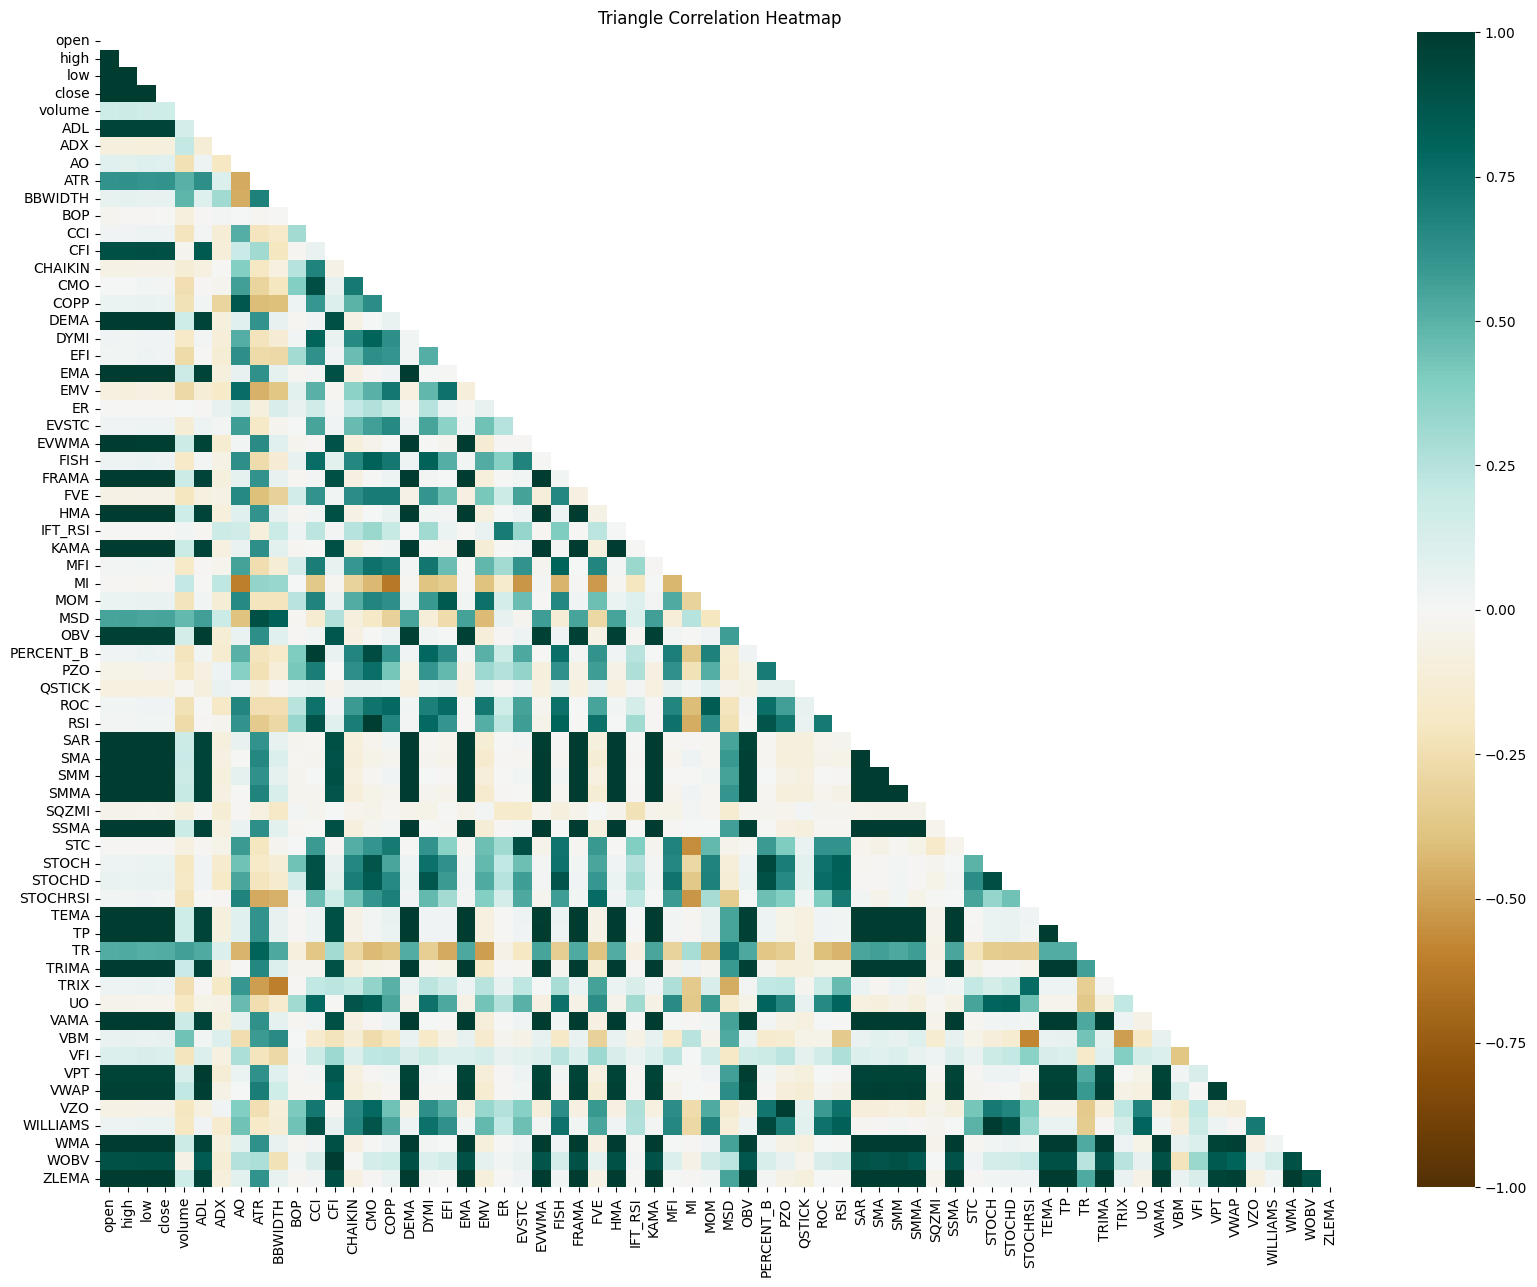

In [43]:
plt.figure(figsize=(20,15))# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(sp500_df.corr(), dtype=bool))
heatmap = sns.heatmap(sp500_df.corr(), mask=mask, vmin=-1, vmax=1, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap')

In [30]:
sp500_df_with_time = add_time_features(sp500_df)
sp500_df_with_time.head(20)

,open,high,low,close,volume,ADL,ADX,AO,ATR,BBWIDTH,...,WILLIAMS,WMA,WOBV,ZLEMA,sin_weekday,cos_weekday,sin_monthday,cos_monthday,sin_yearday,cos_yearday
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,-1.299113,-1.286708,-1.293664,-1.282928,0.049746,-1.833595,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.100389,-1.275609,0.000000,1.000000,0.724793,0.688967,0.068802,0.997630
2010-01-05,-1.282826,-1.283933,-1.280318,-1.279357,-1.377868,-1.830133,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.100389,-1.275609,0.781831,0.623490,0.848644,0.528964,0.085965,0.996298
2010-01-06,-1.279741,-1.281359,-1.275947,-1.278730,0.983417,-1.828580,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.098638,-1.275609,0.974928,-0.222521,0.937752,0.347305,0.103102,0.994671
2010-01-07,-1.279174,-1.278071,-1.278627,-1.274127,1.266984,-1.822062,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.085015,-1.275609,0.433884,-0.900969,0.988468,0.151428,0.120208,0.992749
2010-01-08,-1.274875,-1.275126,-1.273635,-1.270798,0.428625,-1.816325,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.076811,-1.275609,-0.433884,-0.900969,0.998717,-0.050649,0.137279,0.990532
2010-01-09,-1.274875,-1.275126,-1.273635,-1.270798,0.428625,-1.810589,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.076811,-1.275609,-0.974928,-0.222521,0.968077,-0.250653,0.154309,0.988023
2010-01-10,-1.274875,-1.275126,-1.273635,-1.270798,0.428625,-1.804853,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.076811,-1.275609,-0.781831,0.623490,0.897805,-0.440394,0.171293,0.985220
2010-01-11,-1.269371,-1.270752,-1.267726,-1.268775,0.301304,-1.803112,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.071975,-1.275609,0.000000,1.000000,0.790776,-0.612106,0.188227,0.982126
2010-01-12,-1.271546,-1.276714,-1.278168,-1.279660,0.739357,-1.804878,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.100803,-1.275609,0.781831,0.623490,0.651372,-0.758758,0.205104,0.978740


In [31]:
sliding_window_split = sliding_window(sp500_df_with_time, window_size=10)
sliding_window_split[0]

,open,high,low,close,volume,ADL,ADX,AO,ATR,BBWIDTH,...,WILLIAMS,WMA,WOBV,ZLEMA,sin_weekday,cos_weekday,sin_monthday,cos_monthday,sin_yearday,cos_yearday
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,-1.299113,-1.286708,-1.293664,-1.282928,0.049746,-1.833595,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.100389,-1.275609,0.000000,1.000000,0.724793,0.688967,0.068802,0.997630
2010-01-05,-1.282826,-1.283933,-1.280318,-1.279357,-1.377868,-1.830133,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.100389,-1.275609,0.781831,0.623490,0.848644,0.528964,0.085965,0.996298
2010-01-06,-1.279741,-1.281359,-1.275947,-1.278730,0.983417,-1.828580,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.098638,-1.275609,0.974928,-0.222521,0.937752,0.347305,0.103102,0.994671
2010-01-07,-1.279174,-1.278071,-1.278627,-1.274127,1.266984,-1.822062,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.085015,-1.275609,0.433884,-0.900969,0.988468,0.151428,0.120208,0.992749
2010-01-08,-1.274875,-1.275126,-1.273635,-1.270798,0.428625,-1.816325,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.076811,-1.275609,-0.433884,-0.900969,0.998717,-0.050649,0.137279,0.990532
2010-01-09,-1.274875,-1.275126,-1.273635,-1.270798,0.428625,-1.810589,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.076811,-1.275609,-0.974928,-0.222521,0.968077,-0.250653,0.154309,0.988023
2010-01-10,-1.274875,-1.275126,-1.273635,-1.270798,0.428625,-1.804853,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.076811,-1.275609,-0.781831,0.623490,0.897805,-0.440394,0.171293,0.985220
2010-01-11,-1.269371,-1.270752,-1.267726,-1.268775,0.301304,-1.803112,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.071975,-1.275609,0.000000,1.000000,0.790776,-0.612106,0.188227,0.982126
2010-01-12,-1.271546,-1.276714,-1.278168,-1.279660,0.739357,-1.804878,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.100803,-1.275609,0.781831,0.623490,0.651372,-0.758758,0.205104,0.978740


In [47]:
df = pd.read_csv('EURUSD1.csv', sep='\t', parse_dates=True)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

<Axes: xlabel='date'>

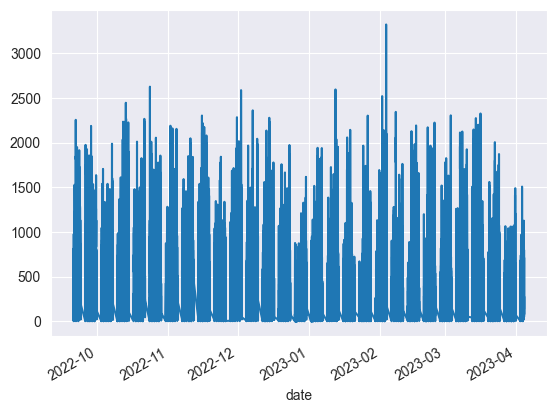

In [51]:
df['volume'].plot()

<Axes: xlabel='date'>

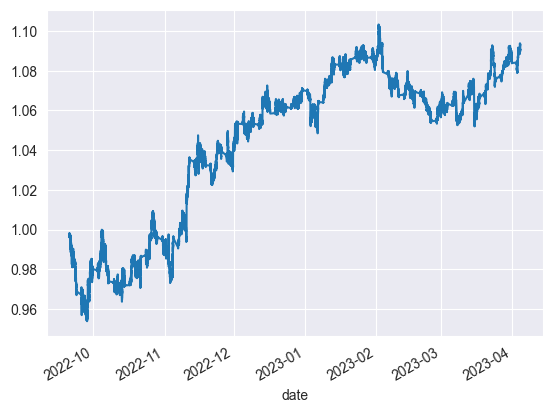

In [52]:
df['close'].plot()